In this notebook, I present some basic functions of PyTorch for biginner like me. I have picked up these functions and checked their operations with elementary Python code.

[PyTorch tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and [ @pestipeti's notebook](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)(which is one of the most famous notebook in "Global Wheat Detection") provided useful reference points for my understanding. I have compared the tutorial with the notebook as shown below. Then, I present 2 fuctions operation, "transform()" and "DataLoader()".

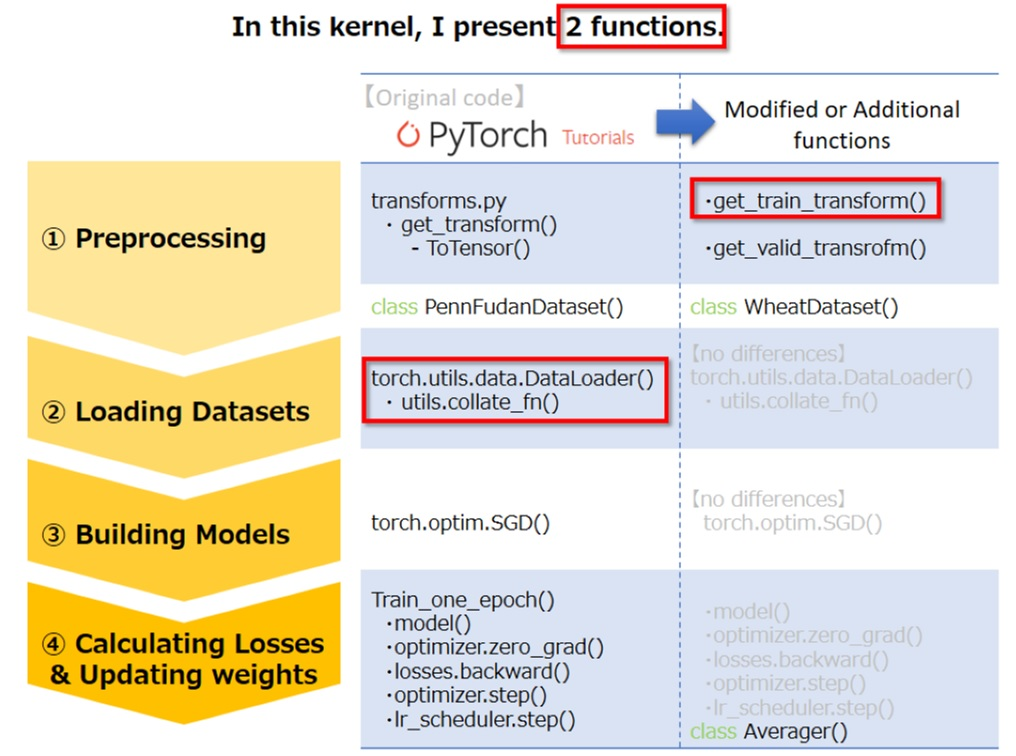

# Overview:
1. Show a wheat image and some bboxes
2. transform() operation
3. DataLoader() operation

# 1. Show a wheat image and some bboxes

In [ ]:
import pandas as pd
train = pd.read_csv('../input/global-wheat-detection/train.csv')
train

show the first image; "*image_id = b6ab77fd7*"

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img_1st = mpimg.imread('../input/global-wheat-detection/train/b6ab77fd7.jpg')
# imgplot = plt.imshow(img_1st)

In [ ]:
import cv2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

img_1st = cv2.imread('../input/global-wheat-detection/train/b6ab77fd7.jpg') 

# Readed on cv2 format is BGR. But matplotlib shows as RGB format.
img_1st = cv2.cvtColor(img_1st, cv2.COLOR_BGR2RGB)
print(img_1st.shape)
plt.imshow(img_1st)

show bboxes on the first image

In [ ]:
data_1st_image = train[train['image_id']=="b6ab77fd7"]
#print(data_1st_image)

In [ ]:
import re
import numpy as np

data_bboxes = data_1st_image['bbox']

b_list = [0,0,0,0]
for b_str in data_bboxes:
    b_value = np.array(re.findall("([0-9]+[.]?[0-9]*)",b_str))
    b_list = np.vstack([b_list,b_value])

b_list = b_list[1:]
#print(b_list)
#b_list.shape

In [ ]:
data_1st_image.loc[:,'x'] = b_list.T[0].astype(np.float)
data_1st_image.loc[:,'y'] = b_list.T[1].astype(np.float)
data_1st_image.loc[:,'w'] = b_list.T[2].astype(np.float)
data_1st_image.loc[:,'h'] = b_list.T[3].astype(np.float)
#data_1st_image

This bbox value is *COCO Bounding box* format.
To show bboxes with cv2.rectangle, we must convert the format (like a *Pascal VOC Bounding box* format). 

* 　COCO　：　(x-top left, y-top left, width, height)
* 　Pascal VOC　：　(x-top left, y-top left,x-bottom right, y-bottom right)

In [ ]:
boxes = data_1st_image[['x', 'y', 'w', 'h']].values
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
#print(boxes)

In [ ]:
import cv2
import numpy as np

# cv2 can't show with float values. 
boxes_ = boxes.astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes_:
    cv2.rectangle(img_1st,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255,0,0),3)

plt.imshow(img_1st)

# 2. transform() operation

"transform()" function is an argument of preprocessing class in PyTorch【1】. PyTorch tutorial use a typical transform() function; "get_transform()" from train.py【2】. And Albumentations provide some image processing fucntions【3】. So, we can combine these functions and make an original transform().

Let's make an example of original transform() and confirm its operation. One of the most famous notebook in "Global Wheat Detection"【4】is a good example. It has flip and tensor convertion function in transform().


【1】 [PyTorch Tutorials "TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL"](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

【2】[github pytorch/vision/blob/master/references/detection/train.py](https://github.com/pytorch/vision/blob/master/references/detection/train.py)

【3】[github albumentations/albumentations/augmentations/transforms.py](https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py)

【4】[Pytorch Starter - FasterRCNN Train  @pestipeti](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)

According to【1】&【2】, transform works in def __getitem__(). Esperially in 【3】, it needs arguments of "img", "bboxes" and "labels" . 

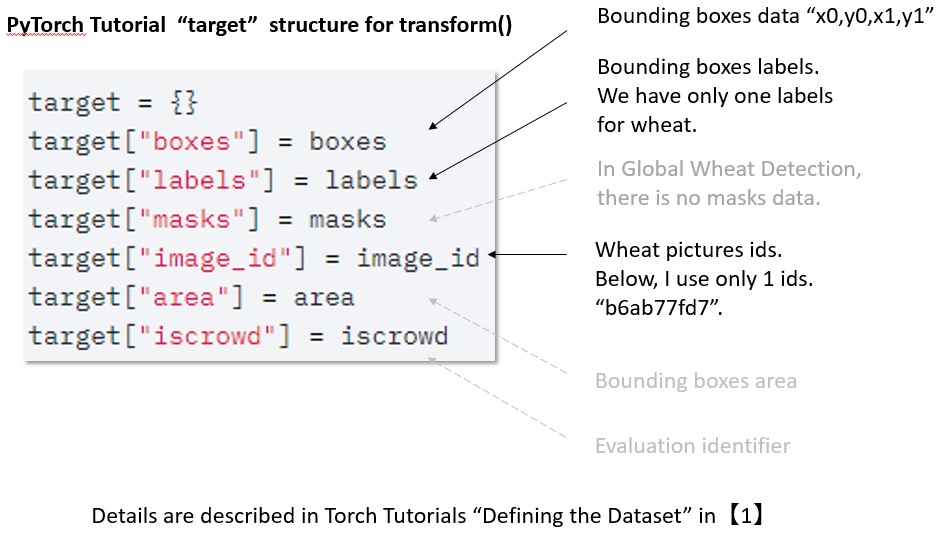

In [ ]:
cols = ['image_id','boxes','labels']
target = pd.DataFrame(index=[], columns=cols)

# get image_id
image_ids = train['image_id'].unique()
image_ids = image_ids[0]  #'b6ab77fd7'

labels = np.ones(len(boxes))

img_1st = cv2.imread('../input/global-wheat-detection/train/b6ab77fd7.jpg') 
img_1st = cv2.cvtColor(img_1st, cv2.COLOR_BGR2RGB).astype(np.float32)
img_1st /= 255.0

target = {
    'image': img_1st,
    'bboxes': boxes,
    'labels':labels
}

transform() code is here,

In [ ]:
import albumentations as Albu
from albumentations.pytorch.transforms import ToTensorV2

# from【4】 code
def get_train_transform():
    return Albu.Compose([
        Albu.Flip(p=1.0),  # In【4】original code, p=0.5 
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

transforms = get_train_transform()
sample = transforms(**target)
img = sample['image']

plt.figure(figsize=(8, 5))
plt.imshow(np.transpose(img, (1, 2, 0)));

Then you can see a fliped image.
The function of ".Flip(p=1.0)" has operated.

# 3. DataLoader() operation

In DataLoader() function makes batch files. And after making the bach files of Wheat data, collate_fn() convert data to the torch.Tensor format. This function is defined external file;utils.py【5】. Let's check the making batch file operation. Code is based on 【4】.

【5】[github.com pytorch/vision/blob/master/references/detection/utils.py](https://github.com/pytorch/vision/blob/master/references/detection/utils.py)

In [ ]:
# from @pestipeti 's notebook【4】
train_ = pd.read_csv('../input/global-wheat-detection/train.csv')

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    return r

train_['x'] = -1
train_['y'] = -1
train_['w'] = -1
train_['h'] = -1


train_[['x', 'y', 'w', 'h']] = np.stack(train_['bbox'].apply(lambda x: expand_bbox(x)))

train_.drop(columns=['bbox'], inplace=True)
train_['x'] = train_['x'].astype(np.float)
train_['y'] = train_['y'].astype(np.float)
train_['w'] = train_['w'].astype(np.float)
train_['h'] = train_['h'].astype(np.float)


image_ids = train_['image_id'].unique()
print("len(image_ids) = {}".format(len(image_ids)))

In [ ]:
from torch.utils.data import DataLoader, Dataset

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return Albu.Compose([
        Albu.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
import torch
from torch.utils.data.sampler import SequentialSampler

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_, '/kaggle/input/global-wheat-detection/train', get_train_transform())

# images, targets, image_ids = next(iter(train_dataset))
# images = list(image.to(device) for image in images)
# print(images)

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

print(len(train_data_loader))

len(image_ids) = 3373 / (3 batchs) ⇒ 1125